# Updating downsampling procedure iteratively

code in this notebook is to validate data preprocessing and downsampling before before incorporating into 

In [1]:
%load_ext autoreload 
%autoreload 2 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from src.utilities.pandas_helpers import flatten_dataframe, strip_columns

2023-06-13 13:25:49.294745: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 13:25:49.427178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 13:25:57.251261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def plot_data(df, title):
    sns.lineplot(data=df, x='time', y='signal',linewidth=0.2)
    # change y axsis to be -2 to 2
    # plt.fill_between(df['time'], df['signal'] - df['signal_sem'], df['signal_mean'] + df['signal_sem'], alpha=.2, color='black')
    plt.ylim(-2, 2)
    plt.title(title)
    

## load raw data

In [3]:
RAW_PATH = '/projects/p31961/gaby_data/aggregated_data/aggregated_data.parquet.gzp'
raw_data = pd.read_parquet(RAW_PATH)

In [7]:
raw_data.head()

,mouse_id,day,event,sensor,time,trial,signal
0,142_237,1,avoid,D1,-25.000000,0,0.955051
1,142_237,1,avoid,D1,-24.998034,0,0.956232
2,142_237,1,avoid,D1,-24.996067,0,0.957714
3,142_237,1,avoid,D1,-24.994102,0,0.959506
4,142_237,1,avoid,D1,-24.992136,0,0.961616


#### missing values in aggreated data

In [ ]:
test_df = raw_data.head()
test_df

def tweak_name(df):
    return (
        df
        .assign(signal_mean=df['signal'].mean())
        .rename(columns = {'signal_mean': 'RENAME'}))
tweak_df = tweak_name(test_df)
tweak_df

In [ ]:
nan_vals = raw_data[raw_data.isna().any(axis=1)]
group_by = ['mouse_id', 'trial',  'day', 'event', 'sensor']
nan_vals.groupby(by = group_by, as_index=False).count()

## function to organize and downsample dataframe

In [8]:
def down_sample_data(df, group_by_cols, agg_dict, ignore_for_sorting, downsample_rate):
    sort_by_list = [col for col in group_by_cols if col != ignore_for_sorting]

    return (
        df
        .dropna(axis = 0, how = 'any') # drop any rows with nans
        .groupby(by=group_by_cols, as_index=False).agg(agg_dict)
        .pipe(flatten_dataframe) # flatten the multi-index
        .pipe(strip_columns) # fixes the column names by stripping _
        .drop(columns = 'index') # drop the index column
        # sort by everything but time and signal columns, 
        # by default puts time column in the correct orientation for downsampling
        .sort_values(by = sort_by_list)
        .rename(columns = {'signal_mean':'signal'}) # rename signal_mean to signal
        [::downsample_rate] # downsample by saving every 100th row
        )


In [9]:
group_by_list = ['time', 'sensor', 'trial', 'mouse_id', 'day', 'event'] # columns to group by
agg_dict = {'signal': ['mean']} # columns are aggregated to the mean and sem signal

downsampled by 100


In [10]:
downsampled = down_sample_data(df = raw_data, 
                               group_by_cols=group_by_list, 
                               agg_dict = agg_dict,
                               ignore_for_sorting = 'time',
                               downsample_rate=100)

In [11]:
downsampled

,time,sensor,trial,mouse_id,day,event,signal
0,-25.000000,D1,0,142_237,1,avoid,0.955051
1277645,-24.803391,D1,0,142_237,1,avoid,1.390726
2555345,-24.606781,D1,0,142_237,1,avoid,1.445842
3833202,-24.410172,D1,0,142_237,1,avoid,1.410818
5111202,-24.213562,D1,0,142_237,1,avoid,1.472887
...,...,...,...,...,...,...,...
215168931,8.065799,DA,29,310_907,3,cue,-0.524122
216448031,8.262408,DA,29,310_907,3,cue,-0.429117
217727131,8.459018,DA,29,310_907,3,cue,-0.098215
219006231,8.655627,DA,29,310_907,3,cue,-0.174924


"downsampled" by 1


In [ ]:
ds_grp = downsampled.groupby(by = ['mouse_id', 'trial',  'day', 'event', 'sensor', 'time'], as_index=False).agg({'signal': ['mean', 'sem']})
ds_grp


In [12]:
fake_downsampled = down_sample_data(df = raw_data, 
                               group_by_cols=group_by_list, 
                               agg_dict = agg_dict,
                               ignore_for_sorting = 'time',
                               downsample_rate=1)

In [ ]:
fake_downsampled

,time,sensor,trial,mouse_id,day,event,signal
0,-25.000000,D1,0,142_237,1,avoid,0.955051
12776,-24.998034,D1,0,142_237,1,avoid,0.956232
25552,-24.996067,D1,0,142_237,1,avoid,0.957714
38328,-24.994102,D1,0,142_237,1,avoid,0.959506
51104,-24.992136,D1,0,142_237,1,avoid,0.961616
...,...,...,...,...,...,...,...
221116746,8.980033,DA,29,310_907,3,cue,-0.437271
221129537,8.981999,DA,29,310_907,3,cue,-0.444461
221142328,8.983965,DA,29,310_907,3,cue,-0.451597
221155119,8.985931,DA,29,310_907,3,cue,-0.458693


day 3, cue and DA only query

In [5]:
day_3_cue_da_query = "day==3 & event=='cue' & sensor=='DA'"

In [15]:
day_3_cue_da_ds = downsampled.query(day_3_cue_da_query)
da_3_cue_da_not_ds = fake_downsampled.query(day_3_cue_da_query)

## Data before and after downsampling

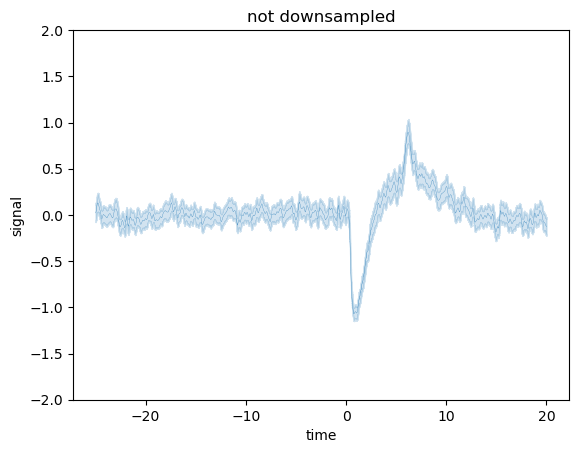

In [16]:
plot_data(da_3_cue_da_not_ds, 'not downsampled')

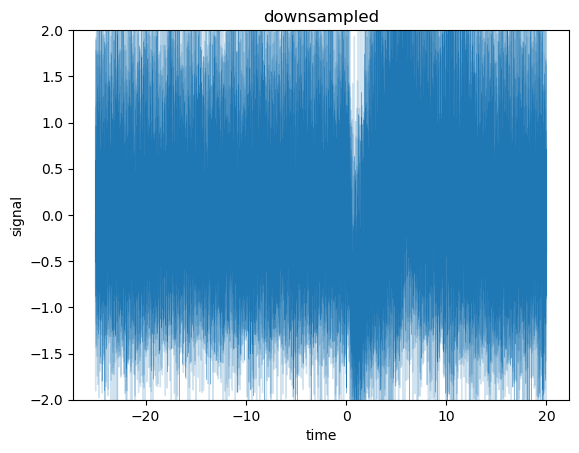

In [17]:
plot_data(day_3_cue_da_ds, 'downsampled')

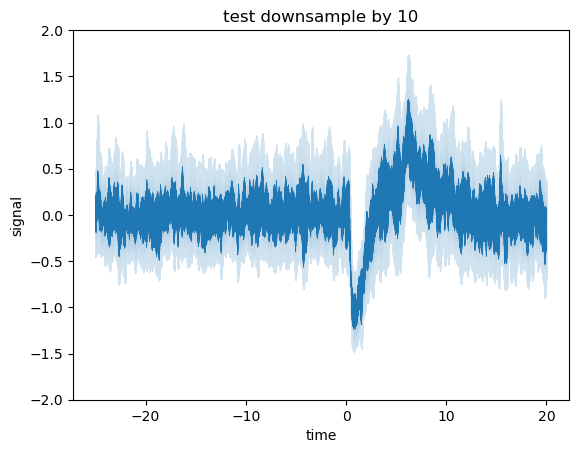

In [21]:
test_downsample_by_10 = fake_downsampled.iloc[::10]
query_by_10 = test_downsample_by_10.query(day_3_cue_da_query)

plot_data(query_by_10, 'test downsample by 10')

#### Does downsampling at the original data have the same effect?


In [4]:
path_to_original_data = '/home/mds8301/gaby_test/Day7/142-237_Day7_Avoid_DA_z_score_DA.h5'

In [5]:
og_df = pd.read_hdf(path_to_original_data)
og_df

,59.20735226639581,121.57730828293634,157.96731911667658,206.80736766823603,250.70731268891168,348.4173925972826,400.31764470108817,458.3476430035479,499.747553215111,531.8777242756731,...,1103.388180599297,1134.9281996346363,1199.5883110619434,1242.2283264256366,1292.2085376835712,1350.3884492970355,1387.888476238335,timestamps,mean,err
0,-0.531609,-0.599563,-0.342489,0.543553,-0.268655,-0.901217,0.595522,0.105800,0.312183,-0.719280,...,-0.719005,2.596853,-0.793617,-0.683335,1.417319,0.210516,0.367095,-25.000000,-0.171792,0.171551
1,-0.530382,-0.596929,-0.355564,0.539301,-0.260548,-0.906595,0.597676,0.096521,0.313179,-0.712107,...,-0.716852,2.609976,-0.793497,-0.702058,1.443982,0.203526,0.388487,-24.999018,-0.174177,0.172721
2,-0.528787,-0.594336,-0.368594,0.535025,-0.252737,-0.912055,0.600074,0.087274,0.314254,-0.704750,...,-0.714435,2.622808,-0.793365,-0.720706,1.470336,0.196442,0.409641,-24.998034,-0.176537,0.173891
3,-0.526819,-0.591785,-0.381573,0.530730,-0.245227,-0.917598,0.602717,0.078061,0.315400,-0.697213,...,-0.711753,2.635348,-0.793221,-0.739273,1.496373,0.189264,0.430547,-24.997051,-0.178873,0.175060
4,-0.524477,-0.589278,-0.394496,0.526423,-0.238020,-0.923223,0.605604,0.068883,0.316615,-0.689498,...,-0.708808,2.647600,-0.793066,-0.757752,1.522081,0.181996,0.451196,-24.996067,-0.181182,0.176228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45772,-0.893901,-0.006066,-0.485830,-0.197161,-0.870593,-0.491660,-0.427906,-1.637023,0.060914,-0.667374,...,-1.425439,-1.289029,-0.180070,-1.413698,-0.806036,-1.474894,0.982104,19.997051,-0.202423,0.194879
45773,-0.889201,-0.032286,-0.494750,-0.191457,-0.866173,-0.491803,-0.425409,-1.629133,0.064392,-0.677958,...,-1.427747,-1.310913,-0.185765,-1.411187,-0.793865,-1.473173,0.969612,19.998034,-0.201844,0.195236
45774,-0.884783,-0.058453,-0.503573,-0.185860,-0.861686,-0.491795,-0.422755,-1.621234,0.068025,-0.688555,...,-1.430052,-1.332600,-0.191737,-1.408665,-0.781454,-1.471506,0.956983,19.999018,-0.201314,0.195597
45775,-0.880646,-0.084559,-0.512297,-0.180374,-0.857133,-0.491639,-0.419944,-1.613333,0.071808,-0.699162,...,-1.432356,-1.354089,-0.197986,-1.406131,-0.768806,-1.469896,0.944218,20.000000,-0.200835,0.195961


In [6]:
og_df_ds = og_df[::100]

<Axes: xlabel='timestamps', ylabel='mean'>

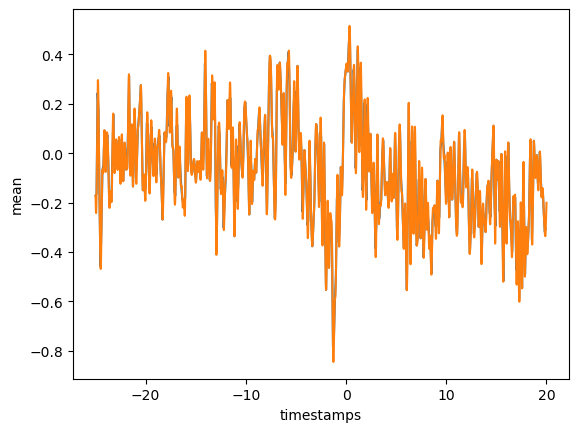

In [7]:
sns.lineplot(data = og_df_ds, x = 'timestamps', y = 'mean')
sns.lineplot(data = og_df, x = 'timestamps', y = 'mean')

In [51]:
rolling = og_df_ds['mean'].rolling(100, center=True).mean()

<Axes: xlabel='timestamps', ylabel='rolling_mean'>

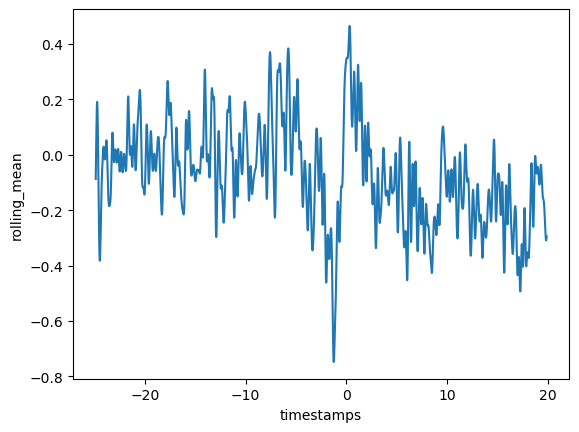

In [74]:
rolling= (og_df.
              assign(rolling_mean = og_df['mean'].rolling(200, center=True).mean())
              .dropna(axis = 0, how = 'any')
)
sns.lineplot(data = rolling, x = 'timestamps', y = 'rolling_mean')

<Axes: xlabel='timestamps', ylabel='rolling_mean'>

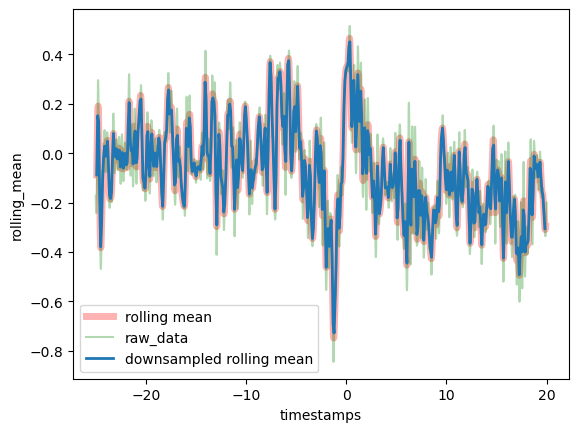

In [95]:
rolling_ds = rolling[::100]

sns.lineplot(data = rolling, x = 'timestamps', y = 'rolling_mean',color = 'red', linewidth = 5, alpha = 0.3, label = 'rolling mean')
sns.lineplot(data = og_df, x = 'timestamps', y = 'mean', color = 'green', alpha = 0.3, label = 'raw_data')
sns.lineplot(data = rolling_ds, x = 'timestamps', y = 'rolling_mean',linewidth = 2, label = 'downsampled rolling mean')

# CONCLUSIONS
* downsampling after preprocessing is not effective at preserving fidelity
* I have gone back to the original GabyProcessor and introduced downsampling at the inital read in of the get_data method for now
* Data is preprocessed




<img src="/Users/michaelschaid/GitHub/dopamine_modeling/data/screenshots/Screenshot 2023-06-12 at 2.55.18 PM.png" alt="image description">


# Check new downsampling procedure

In [12]:
ds_path_raw = '/projects/p31961/gaby_data/aggregated_data/downsampled_aggregated_data.parquet.gzp'
reprocessed_downsampled = pd.read_parquet(ds_path_raw)
reprocessed_downsampled = reprocessed_downsampled.reset_index()

In [13]:
reproc_query = reprocessed_downsampled.query(day_3_cue_da_query)
reproc_query

,index,mouse_id,day,event,sensor,time,trial,signal
4328100,0,145_232,3,cue,DA,-25.000000,0,1.913977
4328101,1,145_232,3,cue,DA,-24.901531,0,0.893275
4328102,2,145_232,3,cue,DA,-24.803064,0,0.819682
4328103,3,145_232,3,cue,DA,-24.704596,0,1.322662
4328104,4,145_232,3,cue,DA,-24.606127,0,1.648973
...,...,...,...,...,...,...,...,...
5075093,13277,312_257,3,cue,DA,19.606127,28,0.488057
5075094,13278,312_257,3,cue,DA,19.704596,28,0.587576
5075095,13279,312_257,3,cue,DA,19.803064,28,0.506356
5075096,13280,312_257,3,cue,DA,19.901531,28,-0.067201


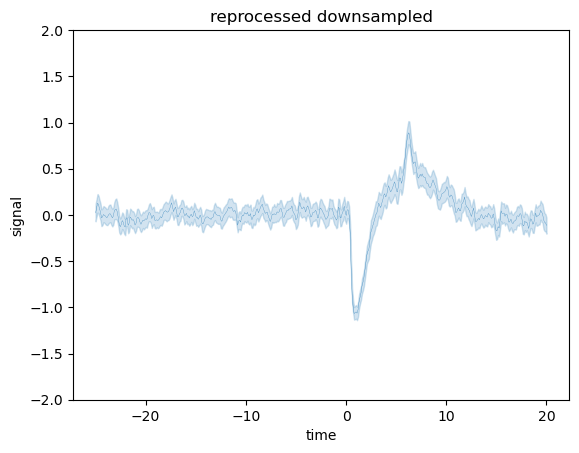

In [14]:
plot_data(reproc_query, 'reprocessed downsampled')

# Problem Solved!